In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image

def load_dib_image(filepath):
    #Rename the file extension from .DIB to .BMP in memory
    with open(filepath, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
        return np.array(img)


## check the images
### DIB are loaded with Pillow and converted to array 
### Note that png are read differently with cv2.imread (y axis is flipped. So used np.flipud())

(512, 512, 3)


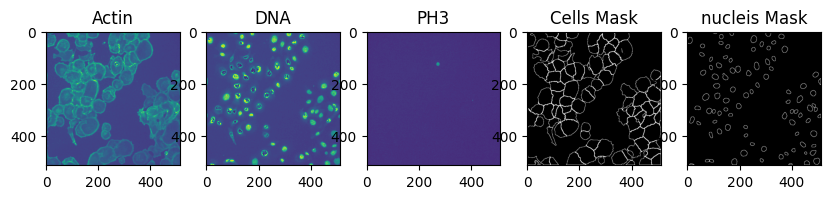

In [5]:
base_dir = '/Users/yuqi/Downloads/BBBC018_v1_images/'
outline_dir = '/Users/yuqi/Downloads/BBBC018_v1_outlines/'
specimen_id = '00733'

# Load three contrast images
actin_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-actin.DIB'))
dna_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-DNA.DIB'))
ph3_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-PH3.DIB'))
print(actin_img.shape)
# Load outline mask (as label for now)
cell_mask = cv2.imread(os.path.join(outline_dir, f'{specimen_id}-cells.png'), cv2.IMREAD_GRAYSCALE)
nuclei_mask = cv2.imread(os.path.join(outline_dir,f'{specimen_id}-nuclei.png'))
# Stack contrasts into a multi-channel image
img_stack = np.stack([actin_img[:,:,0], dna_img[:,:,0], ph3_img[:,:,0]], axis=-1)

N= 5
# Show example
plt.figure(figsize=(10,N))
plt.subplot(1,N,1); plt.imshow(actin_img[:,:,1]); plt.title('Actin')
plt.subplot(1,N,2); plt.imshow(dna_img[:,:,1]); plt.title('DNA')
plt.subplot(1,N,3); plt.imshow(ph3_img[:,:,1]); plt.title('PH3')
plt.subplot(1,N,4); plt.imshow(np.flipud(cell_mask), cmap='gray'); plt.title('Cells Mask')
plt.subplot(1,N,5); plt.imshow(np.flipud(nuclei_mask)); plt.title('nucleis Mask')

plt.show()

In [45]:
def read_train_data(specimen_id,base_dir,outline_dir):
    
    actin_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-actin.DIB'))
    dna_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-DNA.DIB'))
    ph3_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-PH3.DIB'))
    img_stack = np.stack(actin_img[:,:,1])#, dna_img[:,:,0], ph3_img[:,:,0]], axis=-1)
    #img_stack = np.expand_dims(img_stack, axis=-1)

    # Load outline mask (as label for now)
    cell_mask = cv2.imread(os.path.join(outline_dir, f'{specimen_id}-cells.png'), cv2.IMREAD_GRAYSCALE)
    if cell_mask is None:
        return None,None
    cell_mask = (cell_mask > 0).astype(np.float32)
    cell_mask = np.flipud(cell_mask)
    return img_stack,cell_mask

specimen_ids = [file.split('-')[0]  for file in os.listdir(base_dir) if file.endswith('actin.DIB')]

x = []
y = []
for specimen in specimen_ids:
    a,b = read_train_data(specimen,base_dir,outline_dir)
    #print(a.shape)
    if a is None or b is None:
        continue  # Skip if missing data

    a = cv2.resize(a,(224,224))/255.0
    b = cv2.resize(b,(224,224))
    #a = cv2.resize(a,(512,512))/255.0
    #b =  cv2.resize(b,(512,512))/255.0
    
    x.append(a)
    y.append(b)

x=np.array(x)
y = np.array(y) # add a channel dim

x = np.expand_dims(x, axis=-1)
y = np.expand_dims(y, axis=-1)


import torch 
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
x= x.permute(0, 3, 1, 2)
x=x.repeat(1, 3, 1, 1)
y = y.permute(0, 3, 1, 2)
x_train,x_test,y_train,  y_test = train_test_split(x,y,test_size=0.2)
print(f"x_train shape: {x_train.shape}, dtype: {x_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"x_test shape: {x_test.shape}, dtype: {x_test.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(type(x_train))
print(type(y_train))


[ WARN:0@2310.163] global loadsave.cpp:268 findDecoder imread_('/Users/yuqi/Downloads/BBBC018_v1_outlines/10779-cells.png'): can't open/read file: check file path/integrity


x_train shape: torch.Size([44, 3, 224, 224]), dtype: torch.float32
y_train shape: torch.Size([44, 1, 224, 224]), dtype: torch.float32
x_test shape: torch.Size([11, 3, 224, 224]), dtype: torch.float32
y_test shape: torch.Size([11, 1, 224, 224]), dtype: torch.float32
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [33]:
import timm
import torch.nn.functional as F

class ViT_UNet(nn.Module):
    def __init__(self, pretrained=True, n_classes=1):
        super(ViT_UNet, self).__init__()

        #Swin backbone with hierarchical outputs (feature_maps) high resolution -> low semantic, vice versa
        self.encoder = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            features_only=True,
            out_indices=(0, 1, 2, 3)
        )
        encoder_channels = self.encoder.feature_info.channels()  #record the resolution, e.g. [128, 256, 512, 1024]
        #Decoder blocks
        self.decoder4 = self.decoder_block(encoder_channels[3], encoder_channels[2]) #from low resolution upsample to high resolution
        self.decoder3 = self.decoder_block(encoder_channels[2], encoder_channels[1])
        self.decoder2 = self.decoder_block(encoder_channels[1], encoder_channels[0])
        self.decoder1 = self.decoder_block(encoder_channels[0], 64)

        #Final output (dont confuse it with tf.Conv2D, torch.nn's conv2D has in and out channels)
        self.segmentation_head = nn.Conv2d(64, n_classes, kernel_size=1)
    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        features = self.encoder(x)
        for idx, feat in enumerate(features):
            if feat.shape[-1] != feat.shape[-2]:  # Just an example condition
                features[idx] = feat.permute(0, 3, 1, 2)
        
        d4 = self.decoder4(features[3])
        d4_up = F.interpolate(d4, size=features[2].shape[-2:], mode='bilinear', align_corners=False)
        d3 = self.decoder3(d4_up + features[2])

        d3_up = F.interpolate(d3, size=features[1].shape[-2:], mode='bilinear', align_corners=False)
        d2 = self.decoder2(d3_up + features[1])

        d2_up = F.interpolate(d2, size=features[0].shape[-2:], mode='bilinear', align_corners=False)
        d1 = self.decoder1(d2_up + features[0])

        out = self.segmentation_head(d1)
        return out

In [66]:
import torch
import torch.nn.functional as F

def custom_cosine_loss(y_pred, y_true, epsilon=1e-8):
    # Flatten
    y_pred_f = y_pred.view(-1)
    y_true_f = y_true.view(-1)

    # Dot products
    dot_product = torch.sum(y_true_f * y_pred_f)
    dot_product2 = torch.sum((1 - y_true_f) * y_pred_f)

    # L2 norms
    norm_true = torch.sqrt(torch.sum(y_true_f ** 2)) + epsilon
    norm_pred = torch.sqrt(torch.sum(y_pred_f ** 2)) + epsilon
    norm_inverse_true = torch.sqrt(torch.sum((1 - y_true_f) ** 2)) + epsilon

    # Cosine similarities
    cosine_similarity = dot_product / (norm_true * norm_pred)
    cosine_similarity2 = dot_product2 / (norm_inverse_true * norm_pred)

    # Loss: 1 - cosine_similarity + 0.5 * cosine_similarity2
    loss = 1 - cosine_similarity + 0.5 * cosine_similarity2

    return loss

In [28]:
for param in model.vit.parameters():
    param.requires_grad = False

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT_UNet( pretrained=True, n_classes=1).to(device)

In [67]:
criterion = custom_cosine_loss#nn.BCEWithLogitsLoss()  #That is for binary segmentation. Failed. 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        #outputs = outputs.squeeze(1)  # From [batch, 1, H, W] to [batch, H, W]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.3388
Epoch [2/10], Loss: 0.3207
Epoch [3/10], Loss: 0.3140
Epoch [4/10], Loss: 0.2944
Epoch [5/10], Loss: 0.2921
Epoch [6/10], Loss: 0.2882
Epoch [7/10], Loss: 0.2903
Epoch [8/10], Loss: 0.2833
Epoch [9/10], Loss: 0.2762
Epoch [10/10], Loss: 0.2772


In [64]:
from torch.utils.data import TensorDataset, DataLoader, random_split
correct = 0
total = 0
total_loss = 0
total_batches = 0

val_dataset = TensorDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(imgs)

        # Upsample outputs to match mask size, if needed
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        
        # Apply sigmoid to get probabilities between 0 and 1
        probs = torch.sigmoid(outputs)
        preds = probs > 0.5  # boolean mask

        loss = custom_cosine_loss(outputs, masks)
        total_loss += loss.item()
        correct += (preds == masks.bool()).sum().item()  # convert mask to bool for comparison
        total += masks.numel()  # total number of pixels in this batch
        total_batches += 1
        
accuracy = correct / total
average_loss = total_loss / total_batches

print(f"Test Pixel Accuracy: {accuracy:.4f}")
print(f"Average Test Loss: {average_loss:.4f}")

Test Pixel Accuracy: 0.9024
Average Test Loss: 0.1924


In [42]:
def plot_comparison(image, mask, prediction):
    """
    image: numpy array [C, H, W]
    mask: numpy array [1, H, W] or [H, W]
    prediction: numpy array [1, H, W] or [H, W]
    """

    # Remove channel dimension if it's single-channel
    if image.shape[0] == 1:
        image = image[0]
    else:
        image = np.transpose(image, (1, 2, 0))  # For multi-channel (RGB)

    if mask.ndim == 3:
        mask = mask[0]
    if prediction.ndim == 3:
        prediction = prediction[0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

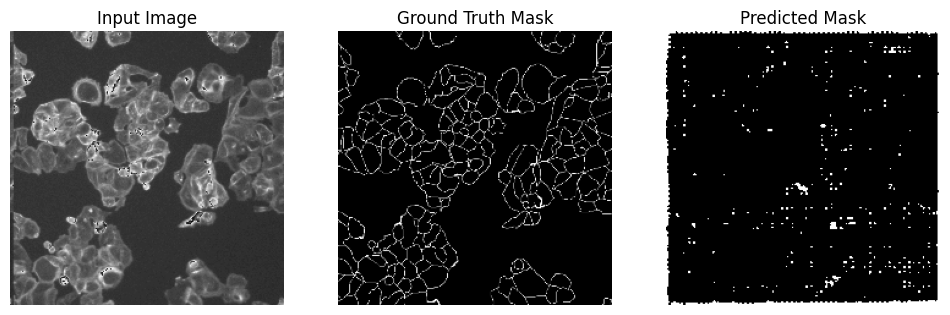

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split

val_dataset = TensorDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Model predictions
        outputs = model(imgs)

        # Resize outputs if needed
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Sigmoid and threshold
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        # Move tensors to CPU and convert to numpy
        imgs_np = imgs.cpu().numpy()
        masks_np = masks.cpu().numpy()
        preds_np = preds.cpu().numpy()

        # Plot the first image in the batch (idx = 0)
        idx = 0
        plot_comparison(imgs_np[idx], masks_np[idx], preds_np[idx])

        # Optional: break after one batch for demo
        break

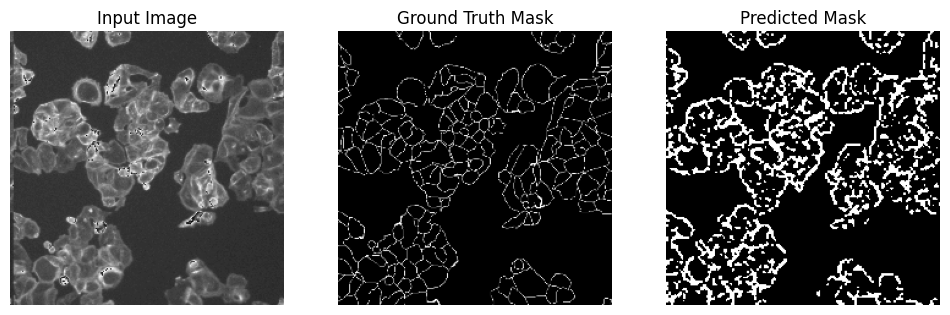

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split

val_dataset = TensorDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Model predictions
        outputs = model(imgs)

        # Resize outputs if needed
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Sigmoid and threshold
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        # Move tensors to CPU and convert to numpy
        imgs_np = imgs.cpu().numpy()
        masks_np = masks.cpu().numpy()
        preds_np = preds.cpu().numpy()

        # Plot the first image in the batch (idx = 0)
        idx = 0
        plot_comparison(imgs_np[idx], masks_np[idx], preds_np[idx])

        # Optional: break after one batch for demo
        break